## Options structural break detection, 3yrs

In [1]:
import os 
import numpy as np
import pandas as pd
from datetime import datetime
from pprint import pprint

In [2]:
import warnings
warnings.filterwarnings(action='once')
warnings.simplefilter('once', category=UserWarning)

In [3]:
from time_series_utils import timeseries_evaluation_metrics_func, mean_absolute_percentage_error,\
                          find_best_ETS_model, get_nth_train_split

Importing plotly failed. Interactive plots will not work.


## Cboe Options Historical Volume and Put/Call Ratios

### Index Options

In [4]:
from datetime import datetime, timedelta
import pickle

In [5]:
with open('IDX_options.pkl', 'rb') as f:
    df2 = pickle.load(f)

In [6]:
df2 = df2[:'2013-01-01']


<AxesSubplot:xlabel='Date'>

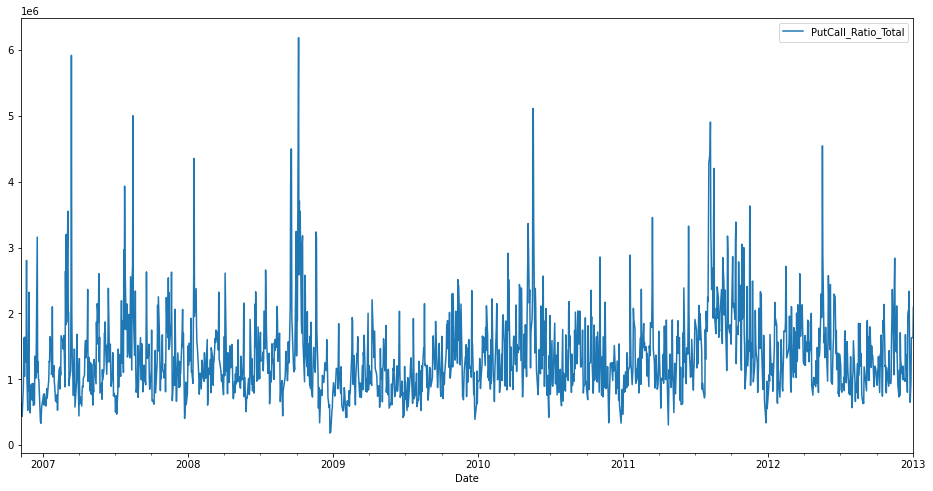

In [7]:
df2.plot(figsize=(16,8))

## What we are going to do. 

start_time + 6 months = interval_1 <- hyperparameter tuning 

then fit and predict the next 1 week. 

new start_time is interval_1 end + 1 weeks => 
start_time_1 + 6 months =  interval_2 <- hyperparameter tuning 

then fix and predict the next 1 week.

Repeat for 156 times. 

Repeat until 12 times.  

that's what we do. then also add new model pytorch_forecasting.

### Fine tune hyperparameter and forecast on moving window of 1 week increment up to 156 weeks (3 years) 

In [8]:
# Value Columns to be used in all models tuning
value_col = 'PutCall_Ratio_Total'

## Holt Winters Exponential Smoothing (ETS)

Find best hyperparameters using train2 and validation data. 

In [9]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [10]:
%%capture

ETS_MAPES = []
steps = 156  # number of windowing steps (unit week)

pred_df = None 

for i in range(steps):
    train_data, val_data, test_data = get_nth_train_split(df2, i, train_week_len=14)
    _, best_MAE, best_ETS_MAE_params = find_best_ETS_model(
        train_data, val_data, value_col=value_col, seasonal_periods=[7,30])
    trend, seasonal, seasonal_period = best_ETS_MAE_params 
    ETS_model_updated = ExponentialSmoothing(train_data[value_col], trend=trend, seasonal=seasonal,\
                                         seasonal_periods=seasonal_period).fit()
    test_pred_ETS = ETS_model_updated.forecast(len(test_data))
    test_pred_ETS = pd.DataFrame(test_pred_ETS, columns=['prediction'])
    if i == 0:
        pred_df = test_pred_ETS
    else:
        pred_df = pd.concat([pred_df, test_pred_ETS])
    MAPE = mean_absolute_percentage_error(test_data[value_col], test_pred_ETS)
    ETS_MAPES.append((MAPE,(test_data.index[0], test_data.index[-1])))

    print("prediction ETS")
    print(test_pred_ETS)
    
    print("*********************************************")
    print()
    print(f"finishing step: {i}")
    print()
    print("**********************************************")
     
print(f"ETS MAPES:\n {ETS_MAPES}")

In [11]:
pred_df.index.name = 'Date'
pred_df.head(3)

prediction
Date                    
2007-02-13  1.177110e+06
2007-02-14  1.154349e+06
2007-02-15  1.129203e+06

In [12]:
import pickle

with open('ETS_interval_14w_IDX_2007-2009.pkl', 'wb') as f:
    pickle.dump(ETS_MAPES, f)

In [13]:

with open('ETS_interval_14w_IDX_pred_2007-2009.pkl', 'wb') as f:
    pickle.dump(pred_df, f)

## ARIMA and SARIMAX Model

In [14]:
## create an ARIMA model
from statsmodels.tsa.arima.model import ARIMA

In [15]:
# force update on hyperparameters
best_params = None 

## Prophet

In [16]:
from prophet import Prophet

## ETS mapes

In [17]:
ETS_MAPES

[(22.144439286597947,
  (Timestamp('2007-02-20 00:00:00', freq='D'),
   Timestamp('2007-02-26 00:00:00', freq='D'))),
 (44.15126614621327,
  (Timestamp('2007-02-27 00:00:00', freq='D'),
   Timestamp('2007-03-05 00:00:00', freq='D'))),
 (19.41264909209597,
  (Timestamp('2007-03-06 00:00:00', freq='D'),
   Timestamp('2007-03-12 00:00:00', freq='D'))),
 (117.70207808974237,
  (Timestamp('2007-03-13 00:00:00', freq='D'),
   Timestamp('2007-03-19 00:00:00', freq='D'))),
 (50.93320233837398,
  (Timestamp('2007-03-20 00:00:00', freq='D'),
   Timestamp('2007-03-26 00:00:00', freq='D'))),
 (36.469168275152455,
  (Timestamp('2007-03-27 00:00:00', freq='D'),
   Timestamp('2007-04-02 00:00:00', freq='D'))),
 (15.964254219390861,
  (Timestamp('2007-04-03 00:00:00', freq='D'),
   Timestamp('2007-04-09 00:00:00', freq='D'))),
 (21.385985319877204,
  (Timestamp('2007-04-10 00:00:00', freq='D'),
   Timestamp('2007-04-16 00:00:00', freq='D'))),
 (46.6797994738469,
  (Timestamp('2007-04-17 00:00:00', fre